ResNetwithLowPrototype(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer_0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer_1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(

/tmp/ipykernel_152828/741312717.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = criterion(x, torch.tensor(labels))  # 计算损失


[Epoch: 1, Batch:   100] loss: 2.032
Train Accuracy: 39 %
[Epoch: 1, Batch:   200] loss: 1.725
Train Accuracy: 43 %
[Epoch: 1, Batch:   300] loss: 1.622
Train Accuracy: 42 %
[Epoch: 1, Batch:   400] loss: 1.558
Train Accuracy: 45 %
[Epoch: 1, Batch:   500] loss: 1.480
Train Accuracy: 54 %
[Epoch: 1, Batch:   600] loss: 1.447
Train Accuracy: 42 %
[Epoch: 1, Batch:   700] loss: 1.420
Train Accuracy: 59 %
Epoch 1 Test Accuracy: 50 %
[Epoch: 2, Batch:   100] loss: 1.272
Train Accuracy: 54 %
[Epoch: 2, Batch:   200] loss: 1.270
Train Accuracy: 56 %
[Epoch: 2, Batch:   300] loss: 1.249
Train Accuracy: 46 %
[Epoch: 2, Batch:   400] loss: 1.214
Train Accuracy: 45 %
[Epoch: 2, Batch:   500] loss: 1.220
Train Accuracy: 53 %
[Epoch: 2, Batch:   600] loss: 1.193
Train Accuracy: 62 %
[Epoch: 2, Batch:   700] loss: 1.198
Train Accuracy: 48 %
Epoch 2 Test Accuracy: 56 %
[Epoch: 3, Batch:   100] loss: 1.034
Train Accuracy: 60 %
[Epoch: 3, Batch:   200] loss: 1.023
Train Accuracy: 60 %
[Epoch: 3, Batch

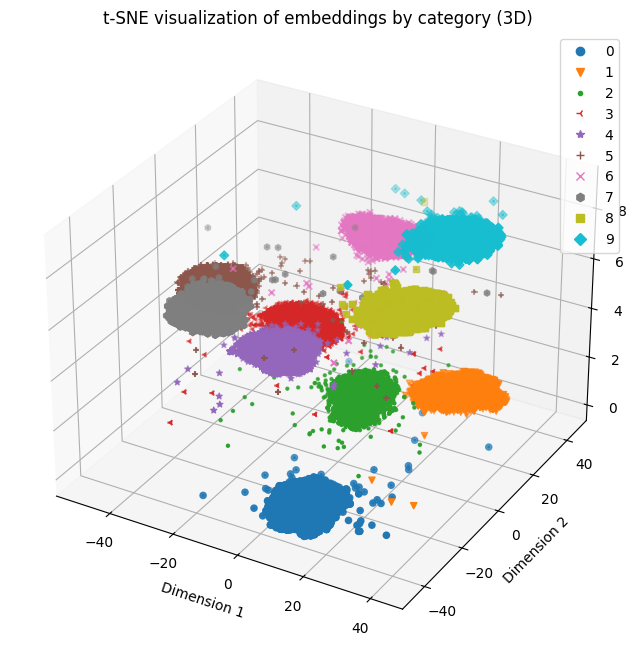

In [1]:
from system.flcore.trainmodel.resnet import *
import torch
model_1 = resnet18_low(num_classes=10, has_bn=True, bn_block_num=4).to("cuda:0")
# model.fc = torch.nn.Identity()
print(model_1)
from socketserver import ThreadingUDPServer
import torchvision
import torchvision.transforms as transforms
raw_data = 'data/Cifar10/'
transform = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = torchvision.datasets.CIFAR10(
        root=raw_data+"rawdata", train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(
root=raw_data+"rawdata", train=False, download=True, transform=transform)
    
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=64, shuffle=True, drop_last=True)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=64, shuffle=True, drop_last=True)
import torch.nn as nn
from torch.optim import SGD
from torch.optim.lr_scheduler import StepLR

model_1.train()
criterion = nn.CrossEntropyLoss()  # 假设我们的任务是分类
optimizer = SGD(model_1.parameters(), lr=0.001, momentum=0.9)  # 使用SGD优化器

# 定义学习率调度器
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.99)
# 训练模型
num_epochs = 20
for epoch in range(num_epochs):
    model_1.train()  # 设置模型为训练模式
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs = inputs.to("cuda:0")
        labels = labels.to("cuda:0")
        optimizer.zero_grad()  # 清空之前的梯度
        _, _, x = model_1(inputs)  # 获得模型的输出
        loss = criterion(x, torch.tensor(labels))  # 计算损失
        loss.backward()  # 反向传播
        optimizer.step()  # 更新参数

        running_loss += loss.item()  # 累加损失

        # 每batch打印一次损失
        if i % 100 == 99:  # 每100个batch打印一次
            total = 0
            correct = 0
            print('[Epoch: %d, Batch: %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0
            _, predicted = torch.max(x.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            print('Train Accuracy: %d %%' % (100 * correct / total))
        torch.cuda.empty_cache()

    # 更新学习率
    scheduler.step()

    # 在每个epoch结束时，验证模型性能
    model_1.eval()  # 设置模型为评估模式
    with torch.no_grad():  # 禁用梯度计算
        correct = 0
        total = 0
        for data in testloader:
            images, labels = data
            images = images.to("cuda")
            _, _, x = model_1(images)
            _, predicted = torch.max(x.data, 1)
            total += labels.size(0)
            correct += (predicted.cpu() == labels).sum().item()

        print('Epoch %d Test Accuracy: %d %%' % (epoch + 1, 100 * correct / total))
def agg_func(protos):
    for [label, proto_list] in protos.items():
        if len(proto_list) > 1:
            proto = 0 * proto_list[0].data
            for i in proto_list:
                proto += i.data
            protos[label] = proto / len(proto_list)
        else:
            protos[label] = proto_list[0] #只有一个，不需要平均了

    return protos #不一定包含所有种类

def save_embedding(protos, is_high=True):
    protos = torch.tensor(protos)
    if is_high: protos.save("high.pt")
    else: protos.save("low.pt")
model_1.eval()
from collections import defaultdict
import torch.nn.functional as F
import tqdm
import copy

protos = defaultdict(list)
device = "cuda:0"
low_protos = defaultdict(list)
with torch.no_grad():
    for i, (x, y) in enumerate(trainloader):
        if type(x) == type([]):
            x[0] = x[0].to(device)
        else:
            x = x.to(device)
        y = y.to(device)
        low, rep, _ = model_1(x)
        rep = F.normalize(rep, dim=1) #[batch, dim(512，对于resnet18)]
        low = F.normalize(low, dim=1)
        for i, yy in enumerate(y):
            y_c = yy.item()
            protos[y_c].append(rep[i, :].detach().data)
            low_protos[y_c].append(low[i, :].detach().data)
        
agg_protos = agg_func(copy.deepcopy(protos))
agg_low_protos = agg_func(copy.deepcopy(low_protos))
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# 假设 protos 是一个字典，键（label）是类别，值（embeddings）是嵌入向量的列表
# 首先，我们需要提取所有的嵌入向量并将它们合并成一个大的列表
all_embeddings = [emb for embeddings in protos.values() for emb in embeddings]

# 将 PyTorch 张量转换为 NumPy 数组
all_embeddings_np = np.array([emb.cpu().numpy() for emb in all_embeddings])

# 应用 t-SNE 算法
tsne = TSNE(n_components=2, perplexity=30, random_state=0, learning_rate=200)
high_embeddings = tsne.fit_transform(all_embeddings_np)
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE

# 提取每个嵌入向量对应的类别标签
labels = [k for k, v in protos.items() for _ in v]

# 为了图例，我们存储每个类别的属性
legend_entries = []
markers = ['o','v','.','3','*','+','x','h','s','D']

# 创建三维散点图
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# 绘制每个类别的点
for label in set(labels):
    indices_to_keep = [i for i, x in enumerate(labels) if x == label]
    # 为每个类别选择不同的颜色和点的形状
    color = f'C{label % 10}'  # 使用 'C0' 到 'C9' 表示颜色
    marker = markers[label]  # 选择一个标记样式
    ax.scatter(high_embeddings[indices_to_keep, 0], high_embeddings[indices_to_keep, 1], label, color=color, marker=marker, label=label)
    # 为图例添加条目
    legend_entries.append(plt.Line2D([0], [0], color=color, marker=marker, linestyle='None', markersize=6, label=label))
    ax.scatter(high_embeddings[indices_to_keep, 0], high_embeddings[indices_to_keep, 1], label, s=2)


# 设置图表标题和坐标轴标签
ax.set_title('t-SNE visualization of embeddings by category (3D)')
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.set_zlabel('Category Layer')

# 显示图例
ax.legend(handles=legend_entries, loc='upper right')
plt.show()